# Test data quality at scale with PyDeequ

Authors: Calvin Wang (calviwan@), Chris Ghyzel (cghyzel@), Joan Aoanan (jaoanan@), Veronika Megler (meglerv@) 

You generally write unit tests for your code, but do you also test your data? Incoming data quality can make or break your machine learning application. Incorrect, missing or malformed data can have a large impact on production systems. Examples of data quality issues are:

* Missing values can lead to failures in production system that require non-null values (NullPointerException).
* Changes in the distribution of data can lead to unexpected outputs of machine learning models.
* Aggregations of incorrect data can lead to wrong business decisions.

In this blog post, we introduce PyDeequ, an open source Python wrapper over [Deequ](https://aws.amazon.com/blogs/big-data/test-data-quality-at-scale-with-deequ/) (an open source tool developed and used at Amazon).  While Deequ is written in Scala, PyDeequ allows you to use its  data quality and testing capabilities from Python and PySpark, the language of choice of many data scientists. PyDeequ democratizes and extends the power of Deequ by allowing you to use it alongside the many data science libraries that are available in that language. Furthermore, PyDeequ allows for fluid interface with [Pandas](https://pandas.pydata.org/) DataFrame as opposed to restricting within Spark DataFrames. 

Deequ allows you to calculate data quality metrics on your dataset, define and verify data quality constraints, and be informed about changes in the data distribution. Instead of implementing checks and verification algorithms on your own, you can focus on describing how your data should look. Deequ supports you by suggesting checks for you. Deequ is implemented on top of [Apache Spark](https://spark.apache.org/) and is designed to scale with large datasets (think billions of rows) that typically live in a distributed filesystem or a data warehouse. PyDeequ gives you access to this capability, but also allows you to use it from the familiar environment of your Python Jupyter notebook.

## Deequ at Amazon 

Deequ is being used internally at Amazon for verifying the quality of many large production datasets. Dataset producers can add and edit data quality constraints. The system computes data quality metrics on a regular basis (with every new version of a dataset), verifies constraints defined by dataset producers, and publishes datasets to consumers in case of success. In error cases, dataset publication can be stopped, and producers are notified to take action. Data quality issues do not propagate to consumer data pipelines, reducing their blast radius. 

Deequ is also used within [Amazon SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html#model-monitor-how-it-works). Now with the availability of PyDeequ, it is finding its way into a broader set of environments - SageMaker Notebooks, AWS Glue, and more.

## Overview of PyDeequ

Let’s look at PyDeequ’s main components, and how they relate to Deequ (shown in Figure 1). 

* Metrics Computation — Deequ computes data quality metrics, that is, statistics such as completeness, maximum, or correlation. Deequ uses Spark to read from sources such as Amazon S3, and to compute metrics through an optimized set of aggregation queries. You have direct access to the raw metrics computed on the data.
* Constraint Verification — As a user, you focus on defining a set of data quality constraints to be verified. Deequ takes care of deriving the required set of metrics to be computed on the data. Deequ generates a data quality report, which contains the result of the constraint verification.
* Constraint Suggestion — You can choose to define your own custom data quality constraints, or use the automated constraint suggestion methods that profile the data to infer useful constraints.
* Python wrappers — You can call each of the Deequ functions using Python syntax. The wrappers translate the commands to the underlying Deequ calls, and return their response.

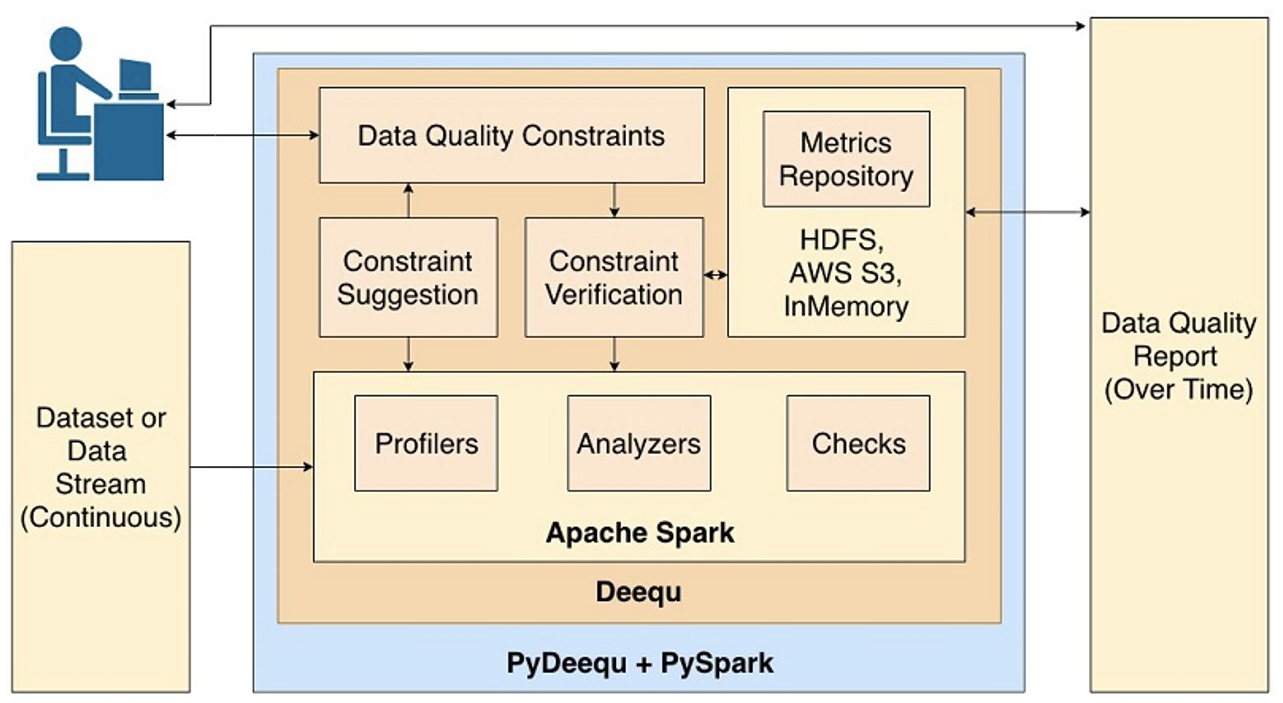

Figure 1. Overview of PyDeequ components. 

## Example 

As a running example, we use [a customer review dataset provided by Amazon](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) on Amazon S3. We have intentionally followed the example in the [Deequ blog](https://aws.amazon.com/blogs/big-data/test-data-quality-at-scale-with-deequ/), to show the similarity in functionality and execution. We begin the way many data science projects do: with initial data exploration and assessment in a Jupyter notebook. 

During the data exploration phase, you’d like to easily answer some basic questions about the data: 

* Are the fields that are supposed to contain unique values, really unique? Are there fields that are missing values? 
* How many distinct categories are there in the categorical fields?
* Are there correlations between some key features?
* If there are two supposedly similar datasets (different categories, or different time periods, say), are they really similar?

Then, we’ll show you how to scale this approach to large-scale datasets, using the same code on an EMR cluster. This is how you’d likely do your ML training, and later as you move into a production setting.

### Setup: Start a PySpark Session in a SageMaker Notebook

In [ ]:
%%bash 

# install PyDeequ via pip 
pip install pydeequ 

In [1]:
from pyspark.sql import SparkSession, Row, DataFrame
import json
import pandas as pd
import sagemaker_pyspark

import pydeequ

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = (SparkSession
    .builder
    .config("spark.driver.extraClassPath", classpath)
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

### We will be using the Amazon Product Reviews dataset -- specifically the Electronics subset. 

In [2]:
df = spark.read.parquet("s3a://amazon-reviews-pds/parquet/product_category=Electronics/")

df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)



## Data Analysis 

Before we define checks on the data, we want to calculate some statistics on the dataset; we call them metrics. As with Deequ, PyDeequ supports a rich set of metrics (they are described in this blog (https://aws.amazon.com/blogs/big-data/test-data-quality-at-scale-with-deequ/) and in this Deequ package (https://github.com/awslabs/deequ/tree/master/src/main/scala/com/amazon/deequ/analyzers)). In the following example, we show how to use the _AnalysisRunner (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/analyzers/runners/AnalysisRunner.scala)_ to capture the metrics you are interested in. 

In [3]:
from pydeequ.analyzers import *

analysisResult = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("review_id")) \
                    .addAnalyzer(ApproxCountDistinct("review_id")) \
                    .addAnalyzer(Mean("star_rating")) \
                    .addAnalyzer(Compliance("top star_rating", "star_rating >= 4.0")) \
                    .addAnalyzer(Correlation("total_votes", "star_rating")) \
                    .addAnalyzer(Correlation("total_votes", "helpful_votes")) \
                    .run()
                    
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-----------+--------------------+-------------------+--------------------+
|     entity|            instance|               name|               value|
+-----------+--------------------+-------------------+--------------------+
|     Column|           review_id|       Completeness|                 1.0|
|     Column|           review_id|ApproxCountDistinct|           3010972.0|
|Mutlicolumn|total_votes,star_...|        Correlation|-0.03451097996538765|
|    Dataset|                   *|               Size|           3120938.0|
|     Column|         star_rating|               Mean|   4.036143941340712|
|     Column|     top star_rating|         Compliance|  0.7494070692849394|
|Mutlicolumn|total_votes,helpf...|        Correlation|  0.9936463809903863|
+-----------+--------------------+-------------------+--------------------+



### You can also get that result in a Pandas Dataframe!

Passing `pandas=True` in any call for getting metrics as DataFrames will return the dataframe in Pandas form! We'll see more of it down the line! 

In [4]:
analysisResult_pd_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult, pandas=True)
analysisResult_pd_df

,entity,instance,name,value
0,Column,review_id,Completeness,1.000000e+00
1,Column,review_id,ApproxCountDistinct,3.010972e+06
2,Mutlicolumn,"total_votes,star_rating",Correlation,-3.451098e-02
3,Dataset,*,Size,3.120938e+06
4,Column,star_rating,Mean,4.036144e+00
5,Column,top star_rating,Compliance,7.494071e-01
6,Mutlicolumn,"total_votes,helpful_votes",Correlation,9.936464e-01


From this, we learn that: 

* review_id has no missing values and approximately 3,010,972 unique values. 
* 74.9% of reviews have a star_rating of 4 or higher 
* total_votes and star_rating are not correlated. 
* helpful_votes and total_votes are strongly correlated 
* the average star_rating is 4.0 
* The dataset contains 3,120,938 reviews. 

## Define and Run Tests for Data

After analyzing and understanding the data, we want to verify that the properties we have derived also hold for new versions of the dataset. By defining assertions on the data distribution as part of a data pipeline, we can ensure that every processed dataset is of high quality, and that any application consuming the data can rely on it.

For writing tests on data, we start with the _VerificationSuite (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/VerificationSuite.scala)_ and add _Checks (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/checks/Check.scala)_ on attributes of the data. In this example, we test for the following properties of our data:

* There are at least 3 million rows in total. 
* review_id is never NULL.
* review_id is unique. 
* star_rating has a minimum of 1.0 and maximum of 5.0. 
* marketplace only contains “US”, “UK”, “DE”, “JP”, or “FR”.
* year does not contain negative values. 

This is the code that reflects the previous statements. For information about all available checks, see _this GitHub repository (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/checks/Check.scala)_. You can run this directly in the Spark shell as previously explained:


In [5]:
from pydeequ.checks import *
from pydeequ.verification import *

check = Check(spark, CheckLevel.Warning, "Amazon Electronic Products Reviews")

checkResult = VerificationSuite(spark) \
    .onData(df) \
    .addCheck(
        check.hasSize(lambda x: x >= 3000000) \
        .hasMin("star_rating", lambda x: x == 1.0) \
        .hasMax("star_rating", lambda x: x == 5.0)  \
        .isComplete("review_id")  \
        .isUnique("review_id")  \
        .isComplete("marketplace")  \
        .isContainedIn("marketplace", ["US", "UK", "DE", "JP", "FR"]) \
        .isNonNegative("year")) \
    .run()

print(f"Verification Run Status: {checkResult.status}")
checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult, pandas=True)
checkResult_df

Python Callback server started!
Verification Run Status: Warning


,check,check_level,check_status,constraint,constraint_status,constraint_message
0,Amazon Electronic Products Reviews,Warning,Warning,SizeConstraint(Size(None)),Success,
1,Amazon Electronic Products Reviews,Warning,Warning,"MinimumConstraint(Minimum(star_rating,None))",Success,
2,Amazon Electronic Products Reviews,Warning,Warning,"MaximumConstraint(Maximum(star_rating,None))",Success,
3,Amazon Electronic Products Reviews,Warning,Warning,"CompletenessConstraint(Completeness(review_id,...",Success,
4,Amazon Electronic Products Reviews,Warning,Warning,UniquenessConstraint(Uniqueness(List(review_id...,Failure,Value: 0.9926566948782706 does not meet the co...
5,Amazon Electronic Products Reviews,Warning,Warning,CompletenessConstraint(Completeness(marketplac...,Success,
6,Amazon Electronic Products Reviews,Warning,Warning,ComplianceConstraint(Compliance(marketplace co...,Success,
7,Amazon Electronic Products Reviews,Warning,Warning,ComplianceConstraint(Compliance(year is non-ne...,Success,


After calling run(), PyDeequ translates your test description into Deequ, which in its turn translates it into a series of Spark jobs which are executed to compute metrics on the data. Afterwards, it invokes your assertion functions (e.g., lambda x: x == 1.0 for the minimum star-rating check) on these metrics to see if the constraints hold on the data. 

Interestingly, the review_id column is not unique, which resulted in a failure of the check on uniqueness. We can also look at all the metrics that Deequ computed for this check by running: 

In [6]:
checkResult_df = VerificationResult.successMetricsAsDataFrame(spark, checkResult, pandas=True)
checkResult_df

,entity,instance,name,value
0,Column,review_id,Completeness,1.000000e+00
1,Column,review_id,Uniqueness,9.926567e-01
2,Dataset,*,Size,3.120938e+06
3,Column,star_rating,Maximum,5.000000e+00
4,Column,star_rating,Minimum,1.000000e+00
5,Column,year is non-negative,Compliance,1.000000e+00
6,Column,"marketplace contained in US,UK,DE,JP,FR",Compliance,1.000000e+00
7,Column,marketplace,Completeness,1.000000e+00


## Automated Constraint Suggestion 

If you own a large number of datasets or if your dataset has many columns, it may be challenging for you to manually define appropriate constraints. Deequ can automatically suggest useful constraints based on the data distribution. Deequ first runs a data profiling method and then applies a set of rules on the result. For more information about how to run a data profiling method, see _this GitHub repository. (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/examples/data_profiling_example.md)_

In [7]:
from pydeequ.suggestions import *

suggestionResult = ConstraintSuggestionRunner(spark) \
             .onData(df) \
             .addConstraintRule(DEFAULT()) \
             .run()

# Constraint Suggestions in JSON format
print(json.dumps(suggestionResult, indent=2))

{
  "constraint_suggestions": [
    {
      "constraint_name": "CompletenessConstraint(Completeness(review_id,None))",
      "column_name": "review_id",
      "current_value": "Completeness: 1.0",
      "description": "'review_id' is not null",
      "suggesting_rule": "CompleteIfCompleteRule()",
      "rule_description": "If a column is complete in the sample, we suggest a NOT NULL constraint",
      "code_for_constraint": ".isComplete(\"review_id\")"
    },
    {
      "constraint_name": "UniquenessConstraint(Uniqueness(List(review_id),None))",
      "column_name": "review_id",
      "current_value": "ApproxDistinctness: 0.9647650802419017",
      "description": "'review_id' is unique",
      "suggesting_rule": "UniqueIfApproximatelyUniqueRule()",
      "rule_description": "If the ratio of approximate num distinct values in a column is close to the number of records (within the error of the HLL sketch), we suggest a UNIQUE constraint",
      "code_for_constraint": ".isUnique(\"review

The above result contains a list of constraints with descriptions and Python code, so that you can directly apply it in your data quality checks.

# Scaling to Production 

So far we’ve shown you how to use these capabilities in the context of data exploration using a Jupyter notebook running on a SageMaker Notebook instance. As your project matures, you’ll want to use the same capabilities on larger and larger datasets, and in a production environment. With PyDeequ, it’s easy to make that transition.

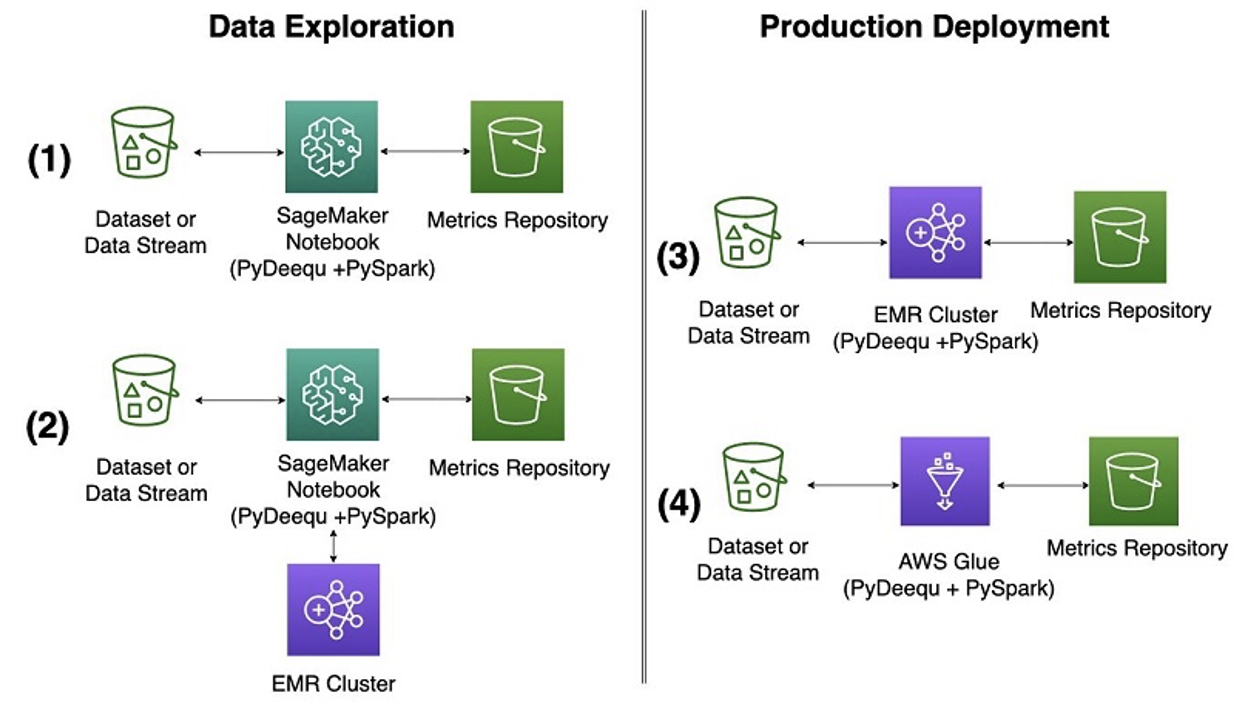

As seen in the diagram above, you can leverage both an AWS EMR cluster and/or AWS Glue for larger or production purposes. 

## More Examples on GitHub

You can find examples of more advanced features at _Deequ’s GitHub page (https://github.com/awslabs/deequ)_:

* Deequ not only provides data quality checks with fixed thresholds. Learn how to use _anomaly detection on data quality metrics (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/examples/anomaly_detection_example.md)_ to apply tests on metrics that change over time.
* Deequ offers support for storing and loading metrics. Learn how to use the _MetricsRepository (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/examples/metrics_repository_example.md)_ for this use case.
* If your dataset grows over time or is partitioned, you can use Deequ’s _incremental metrics computation (https://github.com/awslabs/deequ/blob/master/src/main/scala/com/amazon/deequ/examples/algebraic_states_example.md)_ capability. For each partition, Deequ stores a state for each computed metric. To compute metrics for the union of partitions, Deequ can use these states to efficiently derive overall metrics without reloading the data.

## Additional Resources

Learn more about the inner workings of Deequ in the VLDB 2018 paper “_Automating large-scale data quality verification. (http://www.vldb.org/pvldb/vol11/p1781-schelter.pdf)_”

## Conclusion

This blog post showed you how to use PyDeequ for calculating data quality metrics, verifying data quality metrics, and profiling data to automate the configuration of data quality checks. PyDeequ is available for you now to build your own data quality management pipeline.
